# Packet analysis of a TCP Network

Using the SUEE1 dataset, we will analyse TCP packet data of a 'eduroam' network and build three machine learning classifiers with the objective of identifying IPs running slowloris attack inside the network. 

In [3]:
# Lib importing
import os
import re

import numpy as np
import pandas as pd

In [4]:
# Setting global vars
DATASETS_PATH = "datasets/"

In [5]:
# Reading the original, unchanged dataset after .CSV export
original_df = pd.read_csv(os.path.join(DATASETS_PATH, "original_dataset.csv"), sep=',', index_col="frame.number")

In [4]:
# Number of lines inside the dataset
print("Dataset number of lines: {}".format(len(original_df)))

Dataset number of lines: 2089436


In [5]:
# A little look at our dataset
original_df.head()

,frame.len,frame.protocols,eth.src,eth.dst,ip.proto,ip.len,ip.src,ip.dst,ip.ttl,tcp.flags.res,...,tcp.flags.push,tcp.flags.reset,tcp.flags.syn,tcp.flags.fin,tcp.stream,tcp.seq_raw,tcp.seq,tcp.window_size_value,tcp.time_relative,tcp.time_delta
frame.number,,,,,,,,,,,,,,,,,,,,,
1,66,eth:ethertype:ip:tcp,ff:ff:ff:ff:00:01,ff:ff:ff:ff:00:02,6,52,192.168.0.1,192.168.0.2,64,0,...,0,0,0,1,0,1202351615,1,235,0.000000,0.000000
2,66,eth:ethertype:ip:tcp,ff:ff:ff:ff:00:03,ff:ff:ff:ff:00:01,6,52,192.168.0.2,192.168.0.1,62,0,...,0,0,0,0,0,2705104314,1,245,0.038679,0.038679
3,54,eth:ethertype:ip:tcp,ff:ff:ff:ff:00:01,ff:ff:ff:ff:00:02,6,40,192.168.0.1,192.168.0.3,64,0,...,0,0,0,1,1,3098131932,1,237,0.000000,0.000000
4,54,eth:ethertype:ip:tcp,ff:ff:ff:ff:00:03,ff:ff:ff:ff:00:01,6,40,192.168.0.3,192.168.0.1,126,0,...,0,0,0,0,1,1558776769,1,254,0.001364,0.001364
5,66,eth:ethertype:ip:tcp,ff:ff:ff:ff:00:01,ff:ff:ff:ff:00:02,6,52,192.168.0.1,192.168.0.4,64,0,...,0,0,0,1,2,1199048573,1,235,0.000000,0.000000


In [6]:
# Columns and their respective type
original_df.dtypes

frame.len                  int64
frame.protocols           object
eth.src                   object
eth.dst                   object
ip.proto                   int64
ip.len                     int64
ip.src                    object
ip.dst                    object
ip.ttl                     int64
tcp.flags.res              int64
tcp.flags.ns               int64
tcp.flags.urg              int64
tcp.flags.ack              int64
tcp.flags.push             int64
tcp.flags.reset            int64
tcp.flags.syn              int64
tcp.flags.fin              int64
tcp.stream                 int64
tcp.seq_raw                int64
tcp.seq                    int64
tcp.window_size_value      int64
tcp.time_relative        float64
tcp.time_delta           float64
dtype: object

In [7]:
# Statistical analysis of the quantitative columns
original_df[['frame.len',
             'ip.len',
             'ip.ttl',
             'tcp.window_size_value',
             'tcp.time_relative',
             'tcp.time_delta' 
           ]].describe()

,frame.len,ip.len,ip.ttl,tcp.window_size_value,tcp.time_relative,tcp.time_delta
count,2.089436e+06,2.089436e+06,2.089436e+06,2.089436e+06,2.089436e+06,2.089436e+06
mean,6.234917e+01,7.901674e+02,6.643968e+01,1.011751e+04,-2.929557e+01,-5.852291e-01
std,9.250634e+00,2.815735e+03,1.859239e+01,1.862629e+04,3.708226e+02,6.531709e+01
min,5.400000e+01,4.000000e+01,3.700000e+01,0.000000e+00,-4.293922e+03,-4.293949e+03
25%,5.400000e+01,4.400000e+01,6.200000e+01,2.350000e+02,1.067800e-02,7.000000e-06
50%,6.600000e+01,5.200000e+01,6.400000e+01,3.050000e+02,2.354410e-01,4.300000e-05
75%,6.600000e+01,5.570000e+02,6.400000e+01,8.192000e+03,1.545133e+00,1.274000e-03
max,5.370000e+02,6.521200e+04,2.540000e+02,6.553500e+04,2.689156e+03,2.684000e+03


In [8]:
# Checking how many unique IP addresses there's on the dataset
print("IP sources: {}\n"\
       "IP destinations: {}".format(len(original_df['ip.src'].value_counts()), len(original_df['ip.dst'].value_counts())))

IP sources: 1859
IP destinations: 1858


## Data cleaning

In [9]:
# Discarding useless columns
new_df = original_df.drop(labels=[
    'frame.len',      # Not needed 
    'frame.protocols',# Not needed'
    'eth.src',        # Redundant w/ ip.src
    'eth.dst',        # Redundant w/ ip.dst
    'ip.proto',       # Always 6 (TCP)
    'ip.len',         # Not needed
    'ip.dst',         # Doesn't matter who's being attacked
    'tcp.seq_raw'     # Not needed
], axis=1)

In [10]:
# Grouping and generating aggregates
new_df = new_df.groupby(['tcp.stream', 'ip.src']).agg({
    'ip.ttl': ['mean', 'median'],
    'tcp.time_relative': ['max', 'min', 'mean', 'median'],
    'ip.ttl': ['mean', 'median', 'max', 'min'],
    'tcp.flags.res': ['sum'],
    'tcp.flags.ns': ['sum'],
    'tcp.flags.urg': ['sum'],
    'tcp.flags.ack': ['sum'],
    'tcp.flags.push': ['sum'],
    'tcp.flags.reset': ['sum'],
    'tcp.flags.syn': ['sum'],
    'tcp.flags.fin': ['sum'],
    'tcp.seq': ['max'],
    'tcp.window_size_value': ['max', 'min', 'mean', 'median'],
    'tcp.time_relative': ['max', 'min', 'mean', 'median'],
    'tcp.time_delta': ['max', 'min', 'mean', 'median']
})

# Flattening new columns to index 0
new_df.columns = ["_".join(a) for a in new_df.columns.to_flat_index()]

# Flattening MultiIdx
new_df.index = [f"{num}_{value[1]}" for num, value in enumerate(new_df.index.to_flat_index())]
new_df.index.name = 'ident'

In [11]:
# Generating labels
new_df['attacker'] = new_df.index.str.match('.+_10\.128\.0\.[012]?[0-9][0-9]').astype(int) # Match IP addresses from 10.128.0.0 to 10.128.0.256

In [12]:
# Saving cleansed dataset

new_df.to_csv(os.path.join(DATASETS_PATH, 'labeled_dataset.csv'), sep=',')
new_df.head()

,ip.ttl_mean,ip.ttl_median,ip.ttl_max,ip.ttl_min,tcp.time_relative_max,tcp.time_relative_min,tcp.time_relative_mean,tcp.time_relative_median,tcp.flags.res_sum,tcp.flags.ns_sum,...,tcp.seq_max,tcp.window_size_value_max,tcp.window_size_value_min,tcp.window_size_value_mean,tcp.window_size_value_median,tcp.time_delta_max,tcp.time_delta_min,tcp.time_delta_mean,tcp.time_delta_median,attacker
ident,,,,,,,,,,,,,,,,,,,,,
0_192.168.0.1,64.0,64.0,64,64,0.000000,-2792.830719,-1396.415360,-1396.415360,0,0,...,2,235,0,117.500000,117.5,0.000034,0.000000,0.000017,0.000017,0
1_192.168.0.2,62.0,62.0,62,62,0.038679,-2792.830753,-1396.396037,-1396.396037,0,0,...,1,245,245,245.000000,245.0,0.038679,-2792.869432,-1396.415377,-1396.415377,0
2_192.168.0.1,64.0,64.0,64,64,2.544811,0.000000,1.272406,1.272406,0,0,...,2,237,237,237.000000,237.0,0.000013,0.000000,0.000006,0.000006,0
3_192.168.0.3,126.0,126.0,126,126,2.544837,0.001364,1.697000,2.544798,0,0,...,2,254,0,169.333333,254.0,2.543434,0.000026,0.848275,0.001364,0
4_192.168.0.1,64.0,64.0,64,64,6.003576,0.000000,3.001788,3.001788,0,0,...,2,235,235,235.000000,235.0,0.000021,0.000000,0.000010,0.000010,0


## Using Machine Learning!

### Validation

#### Metrics

In [96]:
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import RocCurveDisplay

def print_class_distribution(series, title):
    print("Dataset total size: {} lines.".format(series.count()))
    counts = series.value_counts()
    percentage = counts[1]/series.count()
    print("The percentage of lines that are attackers is of {}%.".format(percentage*100))
    attacker_count = (series == 1).sum()
    nonattacker_count = (series == 0).sum()
    df = pd.DataFrame({'Occurences': [attacker_count, nonattacker_count]},
                      index=['Attacker', 'Non-Attacker'])
    df.plot.pie(y='Occurences', figsize=(5, 5),
                title="Pie chart for {}".format(title),
                labels=None)


def print_metrics(y_predicted, y_true, title):
    print("---------Metrics for {}-------------".format(title))
    print("The accuracy is {}%.".format(accuracy_score(y_true, y_predicted)*100))
    print("The precision is {}%".format(precision_score(y_true, y_predicted)*100))
    print("The recall score is {}".format(recall_score(y_true, y_predicted)))
    print("The F1 score is {}".format(f1_score(y_true, y_predicted)))

def plot_metrics(classifier, X, y, title):
    # Confusion Matrix
    ConfusionMatrixDisplay.from_estimator(classifier, X, y)
    plt.title("Confusion Matrix for {}".format(title))
    plt.show()
    
    # ROC
    RocCurveDisplay.from_estimator(classifier, X, y)
    plt.title("ROC Curve for {}".format(title))
    plt.show()
    print("-------------------------------------")
    

#### K-Fold Settings

In [4]:
from sklearn.model_selection import KFold

k_splitter = KFold(n_splits=5, shuffle=True, random_state=7)

### Data reading and splits

In [90]:
from sklearn.model_selection import train_test_split

dataset = pd.read_csv(os.path.join(DATASETS_PATH, 'labeled_dataset.csv'), sep=',', index_col='ident')
data = dataset.drop('attacker', axis=1)
labels = dataset['attacker']

train_X, test_X, train_y, test_y = train_test_split(data, labels, test_size=0.2, shuffle=True, random_state=7)

Dataset total size: 194493 lines.
The percentage of lines that are attackers is of 0.5064449620294817%.


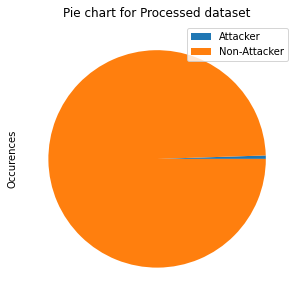

In [97]:
print_class_distribution(labels, "Processed dataset")

### Random Forest

In [6]:
from sklearn.ensemble import RandomForestClassifier
rf_classifier = RandomForestClassifier(n_estimators=125)
rf_classifier = rf_classifier.fit(train_X, train_y)

---------Metrics for Random Forest-------------
The accuracy is 99.98714619913109%.
The precision is 98.28571428571429%
The recall score is 0.9885057471264368
The F1 score is 0.98567335243553


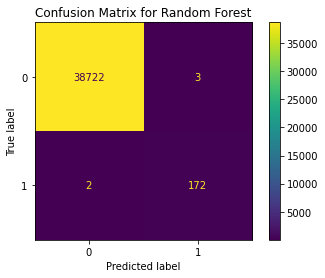

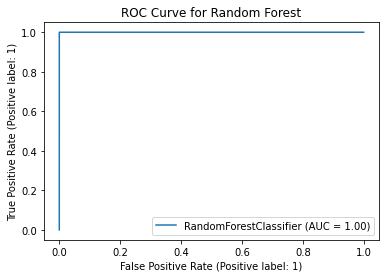

-------------------------------------


In [7]:
rf_predicted = rf_classifier.predict(test_X)

print_metrics(rf_predicted, test_y, "Random Forest")
plot_metrics(rf_classifier, test_X, test_y, "Random Forest")

---------Metrics for Random Forest, Fold 1-------------
The accuracy is 100.0%.
The precision is 100.0%
The recall score is 1.0
The F1 score is 1.0


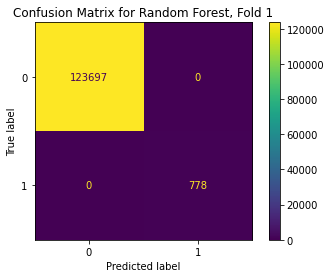

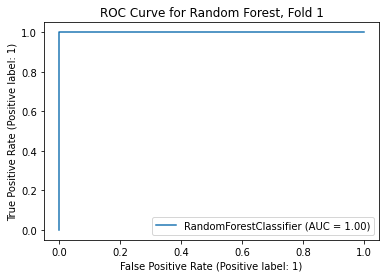

-------------------------------------
---------Metrics for Random Forest, Fold 2-------------
The accuracy is 100.0%.
The precision is 100.0%
The recall score is 1.0
The F1 score is 1.0


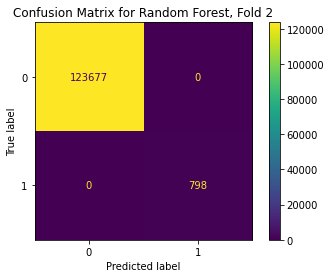

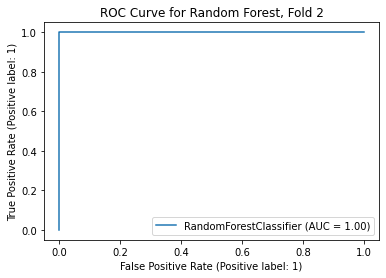

-------------------------------------
---------Metrics for Random Forest, Fold 3-------------
The accuracy is 100.0%.
The precision is 100.0%
The recall score is 1.0
The F1 score is 1.0


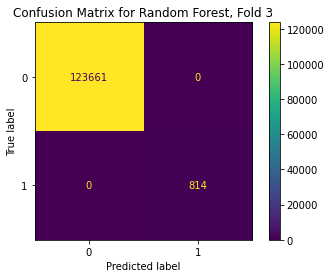

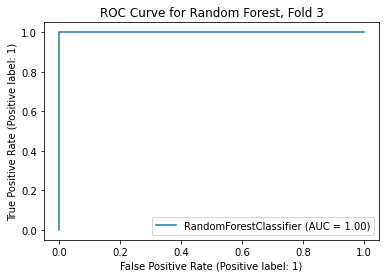

-------------------------------------
---------Metrics for Random Forest, Fold 4-------------
The accuracy is 100.0%.
The precision is 100.0%
The recall score is 1.0
The F1 score is 1.0


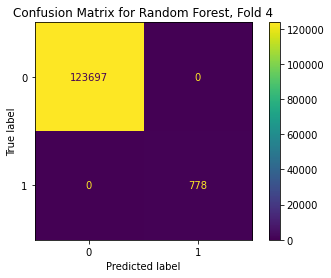

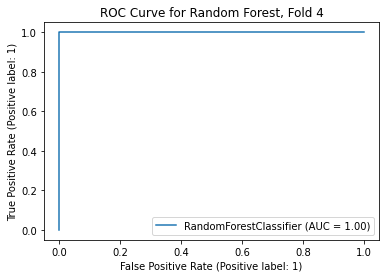

-------------------------------------
---------Metrics for Random Forest, Fold 5-------------
The accuracy is 100.0%.
The precision is 100.0%
The recall score is 1.0
The F1 score is 1.0


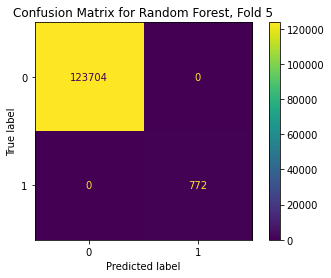

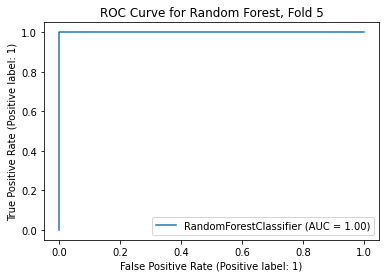

-------------------------------------


In [8]:
## K-fold cross validation
i = 0

for train_idx, test_idx in k_splitter.split(train_X):
    i += 1
    train_idx = np.array(train_idx)
    test_idx = np.array(test_idx)
    kf_train_X, kf_train_y = data.iloc[train_idx], labels.iloc[train_idx]
    kf_test_X, kf_test_y = data.iloc[train_idx], labels.iloc[train_idx]
    
    # New instance of classifier
    k_classifier = RandomForestClassifier(n_estimators=125)
    k_classifier = k_classifier.fit(kf_train_X, kf_train_y)
    
    kfold_prediction = k_classifier.predict(kf_test_X)
    
    print_metrics(kf_test_y, kfold_prediction, "Random Forest, Fold " + str(i))
    plot_metrics(k_classifier, kf_test_X, kf_test_y, "Random Forest, Fold " + str(i))
    

## K-Nearest Neighbors 

---------Metrics for KNearest Neighbor-------------
The accuracy is 99.96143859739325%.
The precision is 96.55172413793103%
The recall score is 0.9491525423728814
The F1 score is 0.9572649572649573


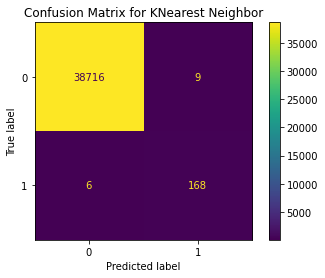

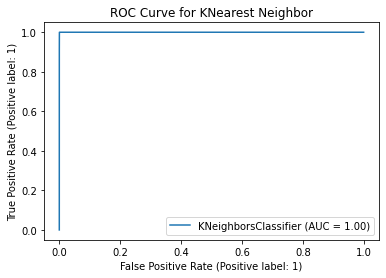

-------------------------------------


In [24]:
from sklearn.neighbors import KNeighborsClassifier

knb_classifier = KNeighborsClassifier(n_neighbors=5)
knb_classifier = knb_classifier.fit(train_X, train_y)

knb_predict = knb_classifier.predict(test_X)
print_metrics(test_y, knb_predict, "KNearest Neighbor")
plot_metrics(knb_classifier, test_X, test_y, "KNearest Neighbor")

---------Metrics for KNB, Fold 1-------------
The accuracy is 99.97509540068286%.
The precision is 99.22879177377892%
The recall score is 0.9686323713927227
The F1 score is 0.9803174603174604


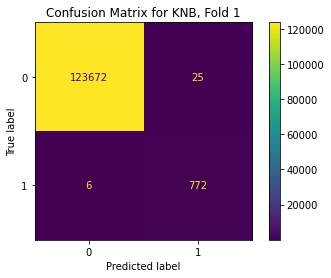

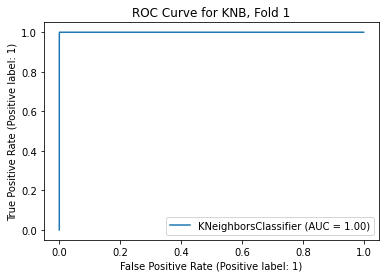

-------------------------------------
---------Metrics for KNB, Fold 2-------------
The accuracy is 99.97750552319744%.
The precision is 98.49624060150376%
The recall score is 0.9800498753117207
The F1 score is 0.9824999999999999


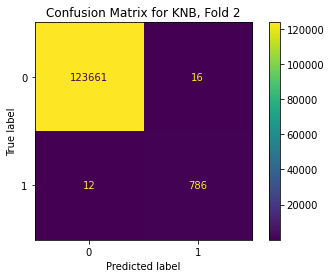

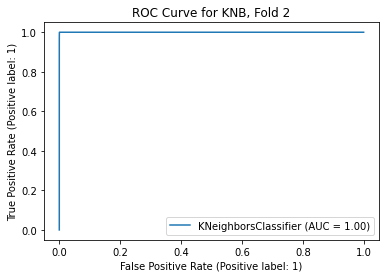

-------------------------------------
---------Metrics for KNB, Fold 3-------------
The accuracy is 99.97107852982526%.
The precision is 98.77149877149877%
The recall score is 0.9686746987951808
The F1 score is 0.9781021897810219


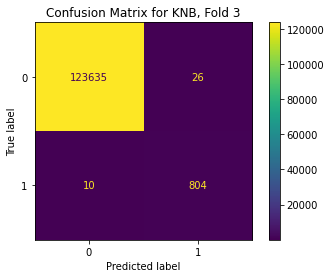

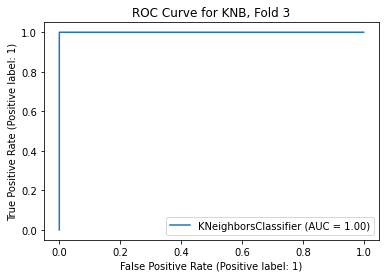

-------------------------------------
---------Metrics for KNB, Fold 4-------------
The accuracy is 99.97670214902591%.
The precision is 98.84318766066839%
The recall score is 0.9746514575411914
The F1 score is 0.9814932992980218


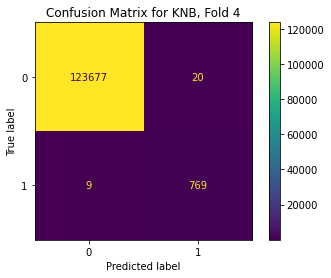

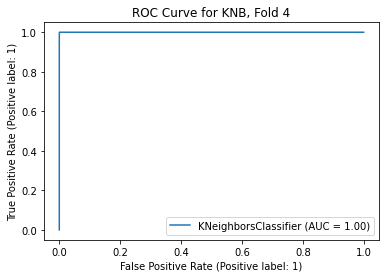

-------------------------------------
---------Metrics for KNB, Fold 5-------------
The accuracy is 99.97188212988848%.
The precision is 98.70466321243524%
The recall score is 0.9682337992376112
The F1 score is 0.9775497113534316


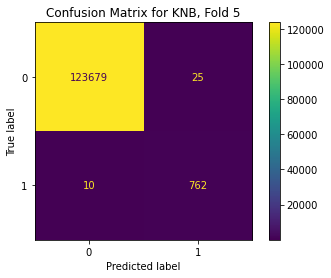

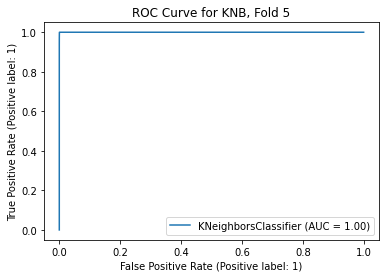

-------------------------------------


In [25]:
## K-fold cross validation
i = 0

for train_idx, test_idx in k_splitter.split(train_X):
    i += 1
    train_idx = np.array(train_idx)
    test_idx = np.array(test_idx)
    kf_train_X, kf_train_y = data.iloc[train_idx], labels.iloc[train_idx]
    kf_test_X, kf_test_y = data.iloc[train_idx], labels.iloc[train_idx]
    
    # New instance of classifier
    knb_classifier = KNeighborsClassifier(n_neighbors=5)
    knb_classifier = knb_classifier.fit(kf_train_X, kf_train_y)
    
    kfold_prediction = knb_classifier.predict(kf_test_X)
    
    print_metrics(kf_test_y, kfold_prediction, "KNB, Fold " + str(i))
    plot_metrics(knb_classifier, kf_test_X, kf_test_y, "KNB, Fold " + str(i))
    

## MLP (Neural Network)

---------Metrics for MLP-------------
The accuracy is 99.67094269775572%.
The precision is 97.91666666666666%
The recall score is 0.27011494252873564
The F1 score is 0.42342342342342343


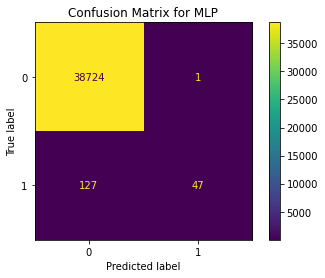

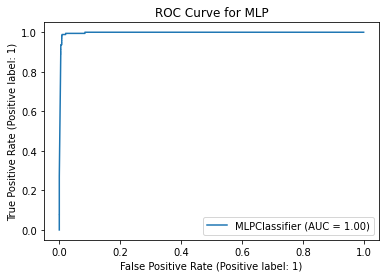

-------------------------------------


In [22]:
from sklearn.neural_network import MLPClassifier

mlp_classifier = MLPClassifier()
mlp_classifier = mlp_classifier.fit(train_X, train_y)

mlp_predict = mlp_classifier.predict(test_X)
print_metrics(mlp_predict, test_y, "MLP")
plot_metrics(mlp_classifier, test_X, test_y, "MLP")

---------Metrics for MLP, Fold 1-------------
The accuracy is 99.5782285599518%.
The precision is 34.19023136246786%
The recall score is 0.953405017921147
The F1 score is 0.5033112582781457


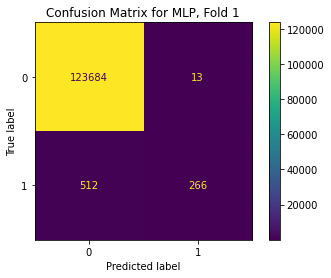

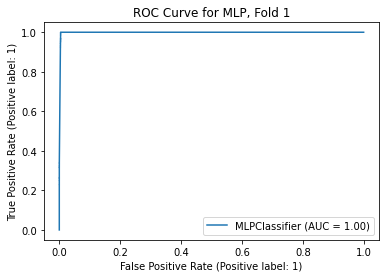

-------------------------------------
---------Metrics for MLP, Fold 2-------------
The accuracy is 99.51074512954409%.
The precision is 43.984962406015036%
The recall score is 0.6842105263157895
The F1 score is 0.5354691075514875


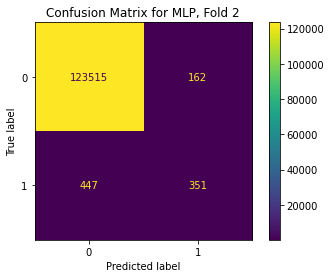

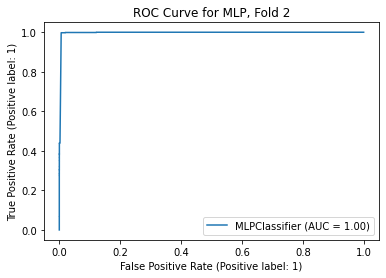

-------------------------------------
---------Metrics for MLP, Fold 3-------------
The accuracy is 99.54930708977706%.
The precision is 32.67813267813268%
The recall score is 0.953405017921147
The F1 score is 0.48673376029277216


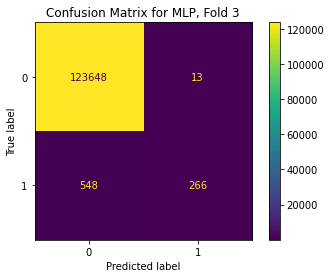

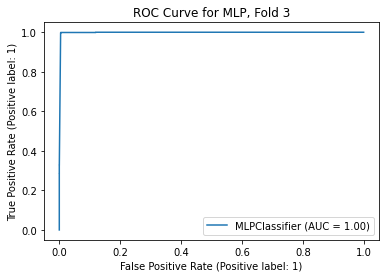

-------------------------------------
---------Metrics for MLP, Fold 4-------------
The accuracy is 99.52118899377385%.
The precision is 29.82005141388175%
The recall score is 0.8226950354609929
The F1 score is 0.4377358490566038


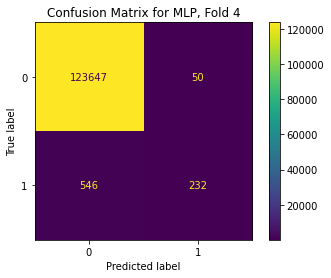

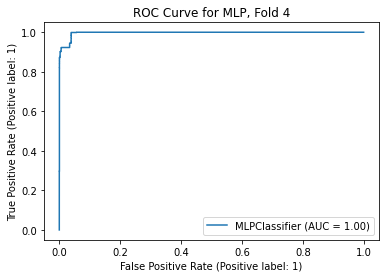

-------------------------------------
---------Metrics for MLP, Fold 5-------------
The accuracy is 99.4930749702754%.
The precision is 42.87564766839378%
The recall score is 0.6353166986564299
The F1 score is 0.5119876256767208


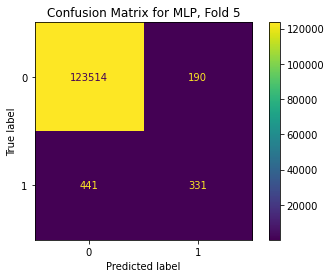

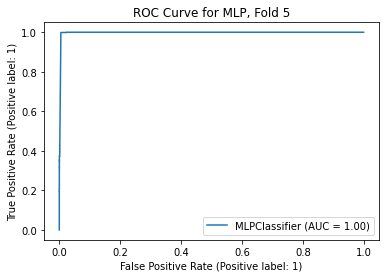

-------------------------------------


In [23]:
## K-fold cross validation
i = 0

for train_idx, test_idx in k_splitter.split(train_X):
    i += 1
    train_idx = np.array(train_idx)
    test_idx = np.array(test_idx)
    kf_train_X, kf_train_y = data.iloc[train_idx], labels.iloc[train_idx]
    kf_test_X, kf_test_y = data.iloc[train_idx], labels.iloc[train_idx]
    
    # New instance of classifier
    mlp_classifier = MLPClassifier()
    mlp_classifier = mlp_classifier.fit(kf_train_X, kf_train_y)
    
    kfold_prediction = mlp_classifier.predict(kf_test_X)
    
    print_metrics(kf_test_y, kfold_prediction, "MLP, Fold " + str(i))
    plot_metrics(mlp_classifier, kf_test_X, kf_test_y, "MLP, Fold " + str(i))